## Comparing Environmental Characteristics and AEWs
### Created by: Quinton Lawton, University of Miami

#### Goals

1) Compare basin wide statistics between 2022 and previous years (can be chosen by user)

2) Compare basic AEW statistics between 2022 and previous years


In [184]:
### First, need to import the required packages 
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pickle

import pandas as pd

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from datetime import timedelta, datetime

from AEW_module import season, AEW, AEW_CCKW #Note: the AEW_module.py object has to be located in same directory as this file

In [185]:
### Settings
year = 2022 #The year you want to plot data from. For now, use the year 2022
year_compare = 2005 #The year of data you want to compare things to.an be anything 1981 - 2022

var_list = ['vo', 'q', 'T', 'U', 'V']
prefix_list = ['_full_', '_full_', '_climo_data_full_', '_full_', '_full_']

### Directories
AEW_NC_dir = '/data/qlawton/AEW_TRACKING_DATA/AEW_TRACK_DATA/NC/' # Location of netcdf files for AEWs
AEW_obj_dir = '/data/qlawton/AEW_TRACKING_DATA/AEW_TRACK_DATA/objects/' #Location of AEW object files
ERA5_dir = '/data/qlawton/ERA5_1DEG/CLIMO/FULL/' #Where ERA5 data is stored (1 degree)

### File names (sorry for the weird long names, that's just how I saved it originally...)
AEW_nc_file_1 = AEW_NC_dir + 'AEW_data_postprocessed__0924_UPDATE_'+str(year)+'_B1-6hr.nc' #Notice it's different based on which year you use

AEW_nc_file_2 = AEW_NC_dir + 'AEW_data_postprocessed__0924_UPDATE_'+str(year_compare)+'_B1-6hr.nc' #Notice it's different based on which year you use

In [186]:
#### Create a list of all of the filenames to load in!
## To do this, we are going to use a for loop. We are going to loop over each variable ("var_list"), create the full file name,
## and then append it to a new list ("full_file_list")

full_file_list1 = [] #Create empty list (for first year)
full_file_list2 = [] #Create emply list (for compare year)

for i in range(len(var_list)): #Loop over all of the variables
    var_in = var_list[i] #The variable
    pref_in = prefix_list[i] #The prefix
    
    dir_start = ERA5_dir+var_in+'/' #Since each ERA5 variable is stored in a directory named the variable name
    full_file1 = dir_start+var_in+pref_in+str(year)+'.nc' #File name
    full_file2 = dir_start+var_in+pref_in+str(year_compare)+'.nc'
    
    ### Append these to final list!
    full_file_list1.append(full_file1)
    full_file_list2.append(full_file2)

In [187]:
### Let's take a look at all of these file names for the first year (1)!
print(full_file_list1)
## And also the second year!
print(full_file_list2)

['/data/qlawton/ERA5_1DEG/CLIMO/FULL/vo/vo_full_2022.nc', '/data/qlawton/ERA5_1DEG/CLIMO/FULL/q/q_full_2022.nc', '/data/qlawton/ERA5_1DEG/CLIMO/FULL/T/T_climo_data_full_2022.nc', '/data/qlawton/ERA5_1DEG/CLIMO/FULL/U/U_full_2022.nc', '/data/qlawton/ERA5_1DEG/CLIMO/FULL/V/V_full_2022.nc']
['/data/qlawton/ERA5_1DEG/CLIMO/FULL/vo/vo_full_2005.nc', '/data/qlawton/ERA5_1DEG/CLIMO/FULL/q/q_full_2005.nc', '/data/qlawton/ERA5_1DEG/CLIMO/FULL/T/T_climo_data_full_2005.nc', '/data/qlawton/ERA5_1DEG/CLIMO/FULL/U/U_full_2005.nc', '/data/qlawton/ERA5_1DEG/CLIMO/FULL/V/V_full_2005.nc']


# Part 1 | Environmental Comparisons 

### Load in enviornmnetal data as xarray datasets

In [188]:
data1_xr = xr.open_mfdataset(full_file_list1) #Loads in all of the files in the first list into one xarray dataset!
data2_xr = xr.open_mfdataset(full_file_list2) #Loads in all of the files from the second list into one xarray dataset!

In [189]:
data1_xr #If we take a look at all of the variables, notice that q, T, u, v, and vo are all contained in this single file!

<xarray.Dataset>
Dimensions:    (longitude: 181, latitude: 81, level: 19, time: 1460)
Coordinates:
  * longitude  (longitude) float32 -120.0 -119.0 -118.0 ... 58.0 59.0 60.0
  * latitude   (latitude) float32 60.0 59.0 58.0 57.0 ... -18.0 -19.0 -20.0
  * level      (level) int32 1000 950 900 850 800 750 ... 300 250 200 150 100
  * time       (time) datetime64[ns] 2022-01-01 ... 2022-12-31T18:00:00
Data variables:
    q          (time, level, latitude, longitude) float32 dask.array<chunksize=(1460, 19, 81, 181), meta=np.ndarray>
    t          (time, level, latitude, longitude) float32 dask.array<chunksize=(1460, 19, 81, 181), meta=np.ndarray>
    u          (time, level, latitude, longitude) float32 dask.array<chunksize=(1460, 19, 81, 181), meta=np.ndarray>
    v          (time, level, latitude, longitude) float32 dask.array<chunksize=(1460, 19, 81, 181), meta=np.ndarray>
    vo         (time, level, latitude, longitude) float32 dask.array<chunksize=(1460, 19, 81, 181), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2023-03-03 22:19:54 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

# Example: Environmental Comparisions


### Here we will discuss: how to take a mean, standard deviation, groupby data, and plotting!
## Motivating Question: how did the mid-level humidity (400-700hPa q) vary between seasons?

In [190]:
level_range = slice(700, 400) #This is the range (in hPa) we want to take an average over

In [191]:
### Step 1: Divide the xarray data into the three months we care about. 
## We care about: July (7), September (8), October (9) mostly

data1_xr_grouped = data1_xr.sel(level = level_range).groupby('time.month') #We will first select the levels we wnat, then divide the data into months, from 1-12
data2_xr_grouped = data2_xr.sel(level = level_range).groupby('time.month') #Do the same with second set of data

### Finally, we are going to take the mean and the standard deviation across the levels
## The levels are averaged between our level range (default 700-400) because we selected this data via the ".sel" command
## We average over all the times in each month group
data1_xr_grouped_mean = data1_xr_grouped.mean(["time", "level"]).compute()
data2_xr_grouped_mean = data2_xr_grouped.mean(["time", "level"]).compute()

## Same, but standard deviation
data1_xr_grouped_std = data1_xr_grouped.std(["time", "level"]).compute()
data2_xr_grouped_std = data2_xr_grouped.std(["time", "level"]).compute()

In [192]:
### Now let's take a look at the data!
data1_xr_grouped_mean

<xarray.Dataset>
Dimensions:    (longitude: 181, latitude: 81, month: 12)
Coordinates:
  * longitude  (longitude) float32 -120.0 -119.0 -118.0 ... 58.0 59.0 60.0
  * latitude   (latitude) float32 60.0 59.0 58.0 57.0 ... -18.0 -19.0 -20.0
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    q          (month, latitude, longitude) float32 0.0006115 ... 0.001446
    t          (month, latitude, longitude) float32 245.7 245.6 ... 270.8 270.8
    u          (month, latitude, longitude) float32 14.19 14.32 ... -0.2163
    v          (month, latitude, longitude) float32 -6.416 -7.1 ... 1.884 1.771
    vo         (month, latitude, longitude) float32 -7.346e-06 ... -4.1e-07

### Notice the xarray above!

Since we grouped by month before running our "mean" command, we averaged each time within the months. That means we now have averages for each month! Pretty cool, huh?

## Now, let's make some basic plots for each year!

### Mean plot

In [74]:
var_to_plot = 'q' #Let's plot specific humidity!
month_list = [7, 8, 9] ## List of months to plot
n_month = len(month_list) #number of months to plot
cmap_in = "Greens" #Colormap we want to use

v_min = 0 #Set minimum value (v_min) as zero 
v_max = data1_xr_grouped_mean[var_to_plot].max()[{}].values #Set maximum value (v_max) as maximum of entire dataset

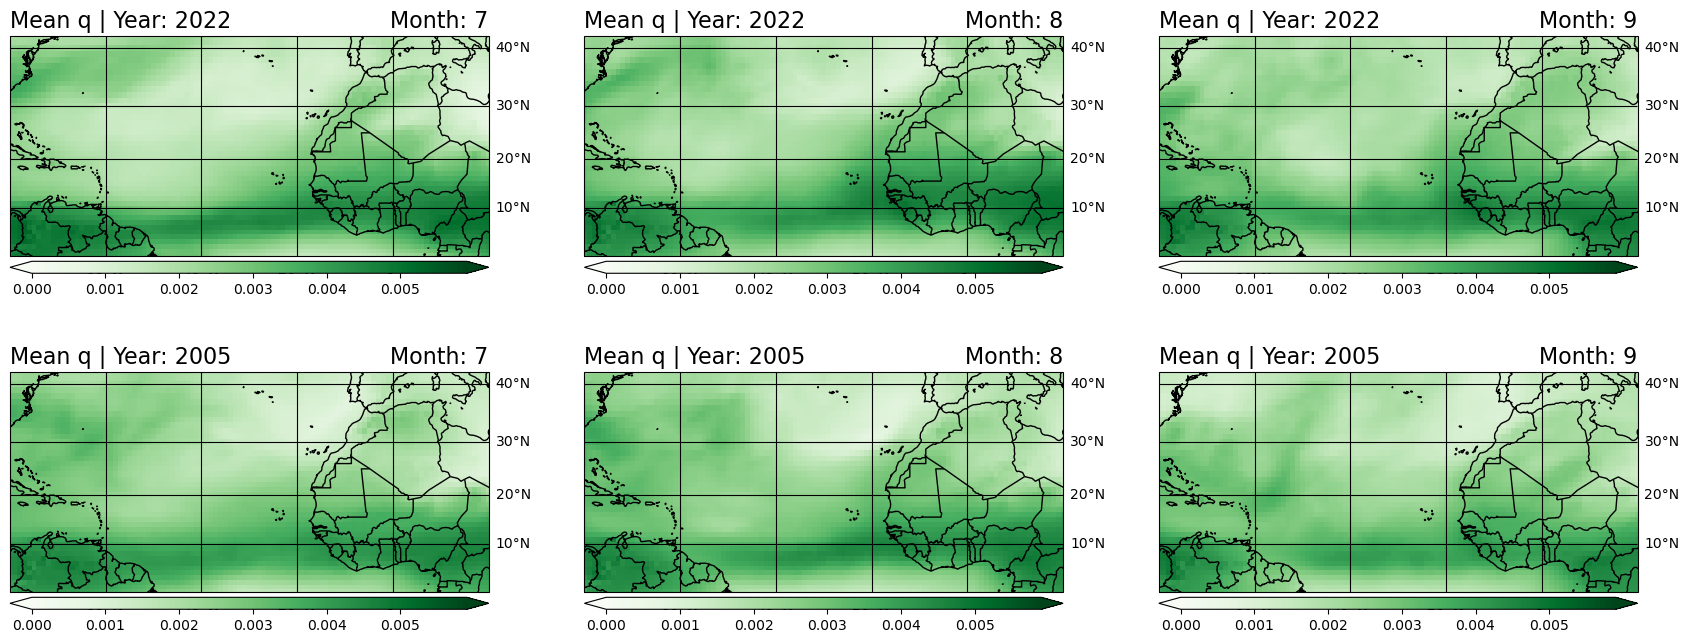

In [98]:
fig = plt.figure(figsize = (21, 8)) ### Make this fairly big, as we are going to make 3 column subplots

for i in range(n_month): #Automatically plot each subplot, to save time!
    
    #### FIRST ROW: THE DATA1 YEAR (DEFAULT IS 2022)
    ax = fig.add_subplot(2,n_month,(i+1), projection = ccrs.Mercator()) #Syntax: add_subplot(rows,columns,subplotnumber)
                                      #Here "n_month" is used to define number of columns, the i is the iteration of the for loop
                                      #and it is used to determine the plot number we are creating with this call with i+1
    
    data_to_plot = data1_xr_grouped_mean.sel(month = month_list[i])[var_to_plot] #Pull out the month of interest (based on list we provided above)
    ## Now actually plot the humidity...
    pl = ax.pcolormesh(data_to_plot.longitude, data_to_plot.latitude, data_to_plot,
                       cmap = cmap_in, vmin = v_min, vmax= v_max, transform = ccrs.PlateCarree())
   
    cbar = plt.colorbar(pl, orientation = 'horizontal', pad = 0.02, aspect = 40, extend = 'both')    
    ### Now let's clean up the figure to make it look nice
    ax.set_extent([-80, 20, 0, 30]) #Lets focus on longitudes 80W (-80) through 20W (20) and the equator (0) to 30N (30)
    ax.add_feature(cfeature.COASTLINE) #Add a coastline
    ax.add_feature(cfeature.BORDERS) #Add political borders
    
    ### Draw gridlines
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'k')
    gl.top_labels = False
    gl.left_labels = False
    
    ### Add a label
    ax.set_title("Mean "+var_to_plot + ' | Year: '+str(year), fontsize = 16, loc = 'left')
    ax.set_title("Month: "+str(month_list[i]), fontsize = 16, loc = 'right')
    
    ##### SECOND ROW: tHE DATA2 YEAR
    
    ax = fig.add_subplot(2,n_month,n_month*1+(i+1), projection = ccrs.Mercator()) #Syntax: add_subplot(rows,columns,subplotnumber)
                                      #Here "n_month" is used to define number of columns, the i is the iteration of the for loop
                                      #and it is used to determine the plot number we are creating with this call with i+1
    
    data_to_plot = data2_xr_grouped_mean.sel(month = month_list[i])[var_to_plot] #Pull out the month of interest (based on list we provided above)
    
    ## Now actually plot the humidity...
    pl = ax.pcolormesh(data_to_plot.longitude, data_to_plot.latitude, data_to_plot,
                       cmap = cmap_in, vmin = v_min, vmax= v_max, transform = ccrs.PlateCarree())
    
    cbar = plt.colorbar(pl, orientation = 'horizontal', pad = 0.02, aspect = 40, extend = 'both')    
    ### Now let's clean up the figure to make it look nice
    ax.set_extent([-80, 20, 0, 30]) #Lets focus on longitudes 80W (-80) through 20W (20) and the equator (0) to 30N (30)
    ax.add_feature(cfeature.COASTLINE) #Add a coastline
    ax.add_feature(cfeature.BORDERS) #Add political borders
    
    ### Draw gridlines
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'k')
    gl.top_labels = False
    gl.left_labels = False
    
    ### Add a label
    ax.set_title("Mean "+var_to_plot + ' | Year: '+str(year_compare), fontsize = 16, loc = 'left')
    ax.set_title("Month: "+str(month_list[i]), fontsize = 16, loc = 'right')
    

### Great! But this doesn't make it too easy to see the differences. To do that, we will plot the actual difference.

In [94]:
diff_mean = data1_xr_grouped_mean - data2_xr_grouped_mean #Compute the difference

cmap_diff = 'BrBG' ## Use the correct colormap for this data too

### Use some smart math to get the right range!

temp_min = diff_mean[var_to_plot].min()[{}].values # Minimum value
temp_max = diff_mean[var_to_plot].max()[{}].values #Maximum value

if np.abs(temp_min)>= np.abs(temp_max): #If absolute value of min larger than max...
    act_min = temp_min
    act_max = np.abs(temp_max) #Maximum is the aboslute value of minimum
else:
    act_min = -temp_max
    act_max = temp_max

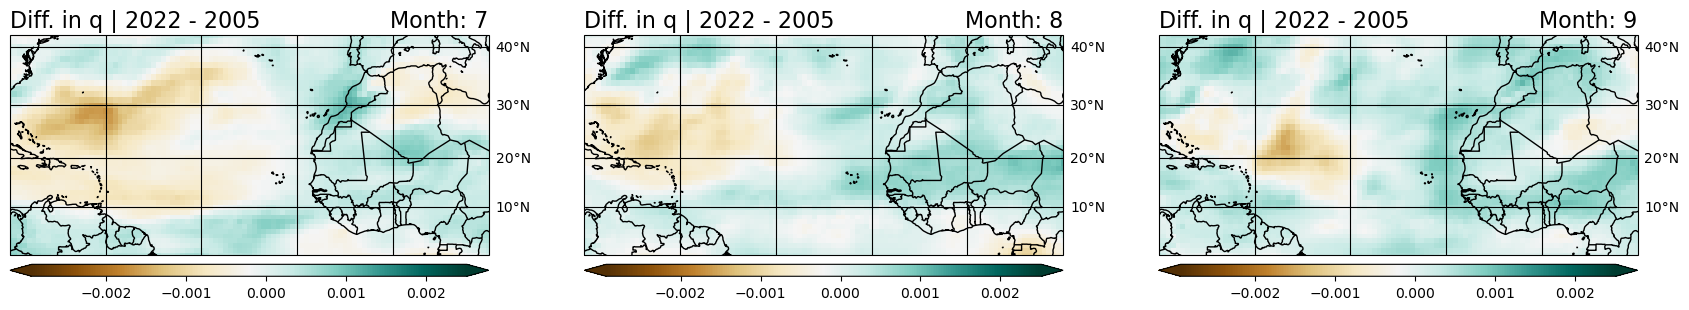

In [101]:
fig = plt.figure(figsize = (21, 6)) ### Make this fairly big, as we are going to make 3 column subplots

for i in range(n_month): #Automatically plot each subplot, to save time!
    
    #### FIRST ROW: THE DATA1 YEAR (DEFAULT IS 2022)
    ax = fig.add_subplot(1,n_month,(i+1), projection = ccrs.Mercator()) #Syntax: add_subplot(rows,columns,subplotnumber)
                                      #Here "n_month" is used to define number of columns, the i is the iteration of the for loop
                                      #and it is used to determine the plot number we are creating with this call with i+1
    
    data_to_plot = diff_mean.sel(month = month_list[i])[var_to_plot] #Pull out the month of interest (based on list we provided above)
    ## Now actually plot the humidity...
    pl = ax.pcolormesh(data_to_plot.longitude, data_to_plot.latitude, data_to_plot,
                       cmap = cmap_diff, vmin = act_min, vmax= act_max, transform = ccrs.PlateCarree())
   
    cbar = plt.colorbar(pl, orientation = 'horizontal', pad = 0.02, aspect = 40, extend = 'both')    
    ### Now let's clean up the figure to make it look nice
    ax.set_extent([-80, 20, 0, 30]) #Lets focus on longitudes 80W (-80) through 20W (20) and the equator (0) to 30N (30)
    ax.add_feature(cfeature.COASTLINE) #Add a coastline
    ax.add_feature(cfeature.BORDERS) #Add political borders
    
    ### Draw gridlines
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'k')
    gl.top_labels = False
    gl.left_labels = False
    
    ### Add a label
    ax.set_title("Diff. in "+var_to_plot +' | '+str(year)+' - '+str(year_compare), fontsize = 16, loc = 'left')
    ax.set_title("Month: "+str(month_list[i]), fontsize = 16, loc = 'right')

## Part 1, Exercise 1: Repeat the above process but now for Standard Deviation!

## Part 1, Exercise 2: Repeat the above but using (1) and different varaible and (2) a different set of three months!

# Part 2 | Comparing different attributes of AEWs

### First let's load and group our AEW data!

In [135]:
### First, we load the netcdf files
AEW1_xr = xr.open_dataset(AEW_nc_file_1, chunks = 'auto') #Opens AEW for first year as netcdf as an xarray object
AEW2_xr = xr.open_dataset(AEW_nc_file_2, chunks = 'auto')

AEW1_xr_grouped = AEW1_xr.groupby('time.month')
AEW2_xr_grouped = AEW2_xr.groupby('time.month')

In [136]:
month_list = [7, 8, 9] ## List of months to plot
#color_list = ['orange', 'r', 'm'] ##List of colors to use
n_month = len(month_list) #number of months to plot

## Next let's plot the AEW tracks side by side for each year

7
8
9


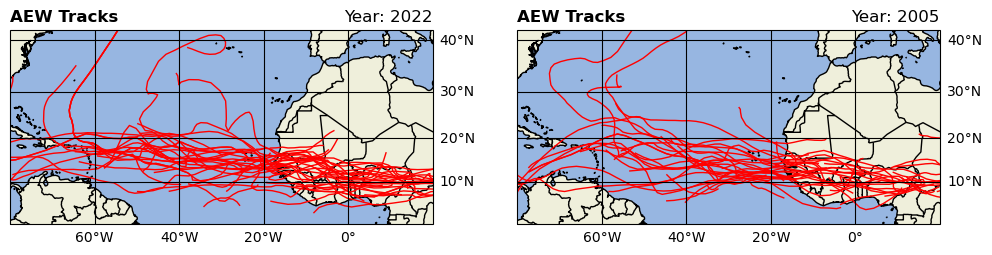

In [143]:
fig = plt.figure(figsize = (12, 10)) ### Make this fairly big, as we are going to make 3 column subplots

ax = fig.add_subplot(121, projection = ccrs.Mercator())
ax2 = fig.add_subplot(122, projection = ccrs.Mercator())    
for i in range(n_month): #Loop over the months
    print(month_list[i])

    AEW1_xr_cut = AEW1_xr_grouped[month_list[i]] ##Pull out the month of interest for first season
    AEW2_xr_cut = AEW2_xr_grouped[month_list[i]] ##Now for second one 
    ax.plot(AEW1_xr_cut.AEW_lon_smooth.T, AEW1_xr_cut.AEW_lat_smooth.T, color = 'r', lw = 1,
           transform = ccrs.PlateCarree(), label = 'Month: '+str(month_list[i])) #Plot the tracks, label with month
    
    ax2.plot(AEW2_xr_cut.AEW_lon_smooth.T, AEW2_xr_cut.AEW_lat_smooth.T, color = 'r', lw = 1,
       transform = ccrs.PlateCarree(), label = 'Month: '+str(month_list[i])) #Plot the tracks, label with month

#### label legend
#ax.legend()
    
#### OTHER FIGURE OPTIONS    
ax.set_title('AEW Tracks', fontsize = 12, fontweight = 'bold', loc = 'left')
ax.set_title('Year: '+str(year), fontsize = 12, loc ='right')

ax2.set_title('AEW Tracks', fontsize = 12, fontweight = 'bold', loc = 'left')
ax2.set_title('Year: '+str(year_compare), fontsize = 12, loc ='right')

### Now let's clean up the figure to make it look nice
ax.set_extent([-80, 20, 0, 30]) #Lets focus on longitudes 80W (-80) through 20W (20) and the equator (0) to 30N (30)
ax.add_feature(cfeature.COASTLINE) #Add a coastline
ax.add_feature(cfeature.BORDERS) #Add political borders
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
### Draw gridlines
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'k')
gl.top_labels = False
gl.left_labels = False

### Now let's clean up the figure to make it look nice
ax2.set_extent([-80, 20, 0, 30]) #Lets focus on longitudes 80W (-80) through 20W (20) and the equator (0) to 30N (30)
ax2.add_feature(cfeature.COASTLINE) #Add a coastline
ax2.add_feature(cfeature.BORDERS) #Add political borders
ax2.add_feature(cfeature.LAND)
ax2.add_feature(cfeature.OCEAN)

### Draw gridlines
gl2 = ax2.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'k')
gl2.top_labels = False
gl2.left_labels = False


### This is pretty messy, so let's try to do what we did before and compare the months!

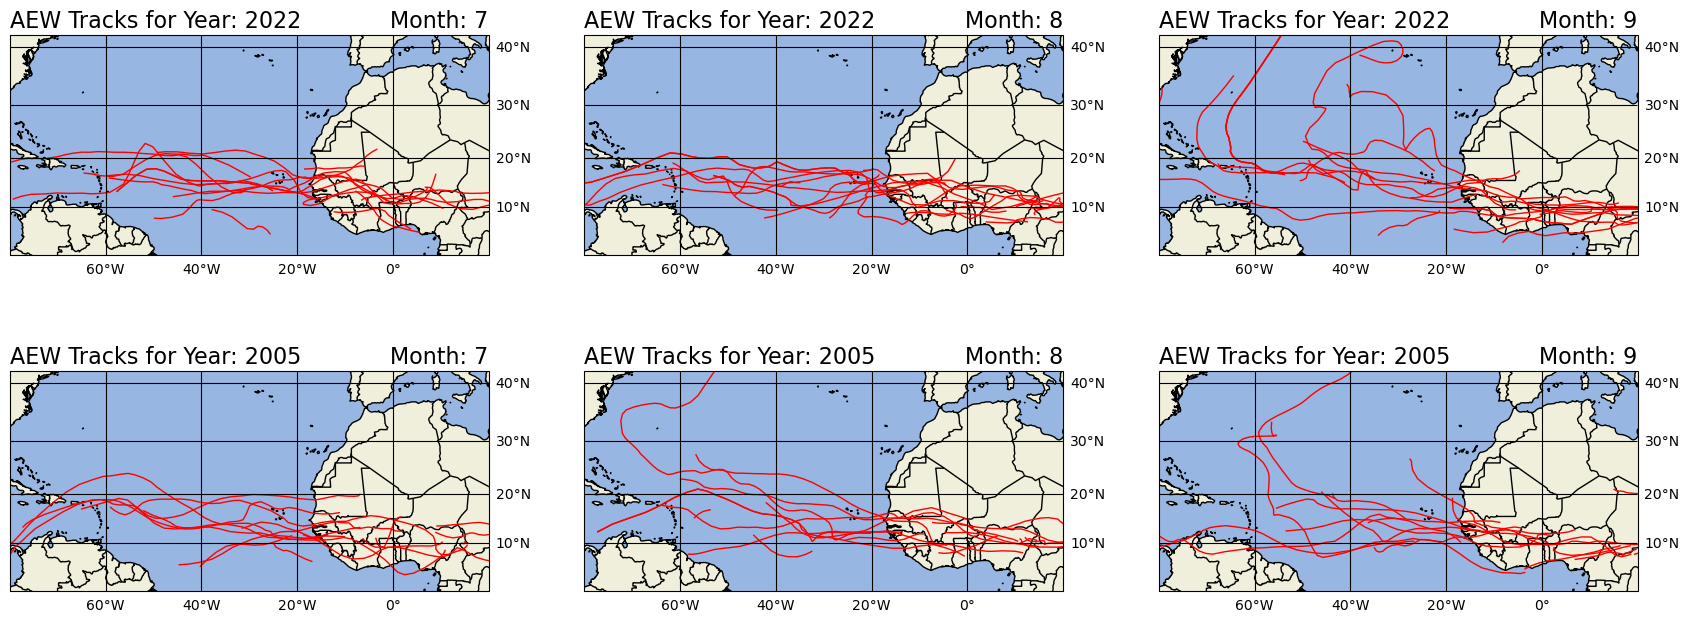

In [147]:
fig = plt.figure(figsize = (21, 8)) ### Make this fairly big, as we are going to make 3 column subplots

for i in range(n_month): #Automatically plot each subplot, to save time!
    
    #### FIRST ROW: THE DATA1 YEAR (DEFAULT IS 2022)
    ax = fig.add_subplot(2,n_month,(i+1), projection = ccrs.Mercator()) #Syntax: add_subplot(rows,columns,subplotnumber)
                                      #Here "n_month" is used to define number of columns, the i is the iteration of the for loop
                                      #and it is used to determine the plot number we are creating with this call with i+1
    
    AEW_to_plot = AEW1_xr_grouped[month_list[i]]
    ## Now plot the AEWs
    ax.plot(AEW_to_plot.AEW_lon_smooth.T, AEW_to_plot.AEW_lat_smooth.T, color = 'r', lw = 1,
           transform = ccrs.PlateCarree(), label = 'Month: '+str(month_list[i])) #Plot the tracks, label with month
    ### Now let's clean up the figure to make it look nice
    ax.set_extent([-80, 20, 0, 30]) #Lets focus on longitudes 80W (-80) through 20W (20) and the equator (0) to 30N (30)
    ax.add_feature(cfeature.COASTLINE) #Add a coastline
    ax.add_feature(cfeature.BORDERS) #Add political borders
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ### Draw gridlines
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'k')
    gl.top_labels = False
    gl.left_labels = False
    
    ### Add a label
    ax.set_title('AEW Tracks for Year: '+str(year), fontsize = 16, loc = 'left')
    ax.set_title("Month: "+str(month_list[i]), fontsize = 16, loc = 'right')
    
    ##### SECOND ROW: tHE DATA2 YEAR
    
    ax = fig.add_subplot(2,n_month,n_month*1+(i+1), projection = ccrs.Mercator()) #Syntax: add_subplot(rows,columns,subplotnumber)
                                      #Here "n_month" is used to define number of columns, the i is the iteration of the for loop
                                      #and it is used to determine the plot number we are creating with this call with i+1
    
    AEW_to_plot = AEW2_xr_grouped[month_list[i]]
    ## Now plot the AEWs
    ax.plot(AEW_to_plot.AEW_lon_smooth.T, AEW_to_plot.AEW_lat_smooth.T, color = 'r', lw = 1,
           transform = ccrs.PlateCarree(), label = 'Month: '+str(month_list[i])) #Plot the tracks, label with month
    

    ### Now let's clean up the figure to make it look nice
    ax.set_extent([-80, 20, 0, 30]) #Lets focus on longitudes 80W (-80) through 20W (20) and the equator (0) to 30N (30)
    ax.add_feature(cfeature.COASTLINE) #Add a coastline
    ax.add_feature(cfeature.BORDERS) #Add political borders
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    
    ### Draw gridlines
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'k')
    gl.top_labels = False
    gl.left_labels = False
    
    ### Add a label
    ax.set_title("AEW Tracks for Year: "+str(year_compare), fontsize = 16, loc = 'left')
    ax.set_title("Month: "+str(month_list[i]), fontsize = 16, loc = 'right')
    

## Let's look at some AEW statistics! 

### Load in AEW object

### [IMPORTANT] Special note: The 2022 file is different than all of the other files...

This is because at the time of writing, not enough satellite data is available to run the CCKW analysis. 

The main difference is that (1) CCKW data is not available for the object files and (2) the "AEW" object class must be used for the 2022 AEW data as compared to the "AEW_CCKW" class. 

Be careful if you switch out the input files, because this will necessitate a line of code to be changed!

In [157]:
AEW1_obj_file = AEW_obj_dir +'AEW_tracks_post_loop_'+str(year)+'.pkl'
AEW2_obj_file = AEW_obj_dir +'AEW_tracks_post_loop_with_CCKW_'+str(year_compare)+'.pkl'

season_obj1 = pickle.load(open(AEW1_obj_file, 'rb')) ## Loads in the season
season_obj2 = pickle.load(open(AEW2_obj_file, 'rb')) ## Loads in the season

### Let's count/compute the following:

1. The number of AEWs that have associated TCs (developers!) versus those that do not
2. The beginning month of time for each AEW
3. The average strength of each AEW, and it's maximum strength

In [176]:
### Call the built in counter within the seasons themselves
n_waves1 = season_obj1.number_of_waves()
n_waves2 = season_obj2.number_of_waves()

## For TCs, we take the list of "waves with TC" and count it's length to get a number
n_waves1_TC = len(season_obj1.waves_with_TC())
n_waves2_TC = len(season_obj2.waves_with_TC())

### First, let's make a bar graph the basic way (non-pandas) to look at the basic overall count and # of TCs

Text(0.5, 1.0, 'AEW Count Comparisons: 2022 vs. 2005')

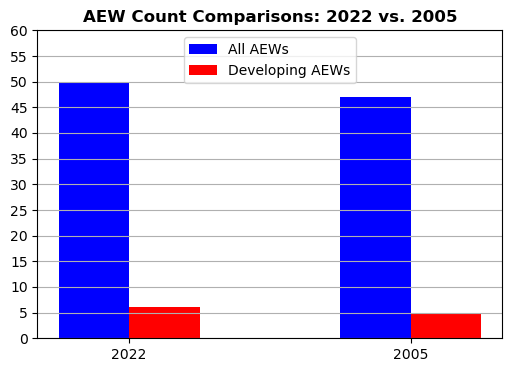

In [220]:
fig = plt.figure(figsize = (6, 4))
ax = fig.add_subplot(111)

bar_width = 0.25
x = np.array([0,1])#0 and 1 are used as placeholders on x-axis, will be renamed
y_ticks = np.arange(0, 61, 5)

### Draw the "bars"
ax.bar(x, [n_waves1, n_waves2], width = bar_width, color = 'b', label = 'All AEWs') #Plot total count
ax.bar(x+bar_width, [n_waves1_TC, n_waves2_TC], width = bar_width, color = 'r', label = 'Developing AEWs') #Plot TC count; notice the manual bar_width offset to put them side by side

### Now we want to label the x-axis correctly: one year should be on the "0" spot and comparison year the "1" spot
ax.set_xticks(x+bar_width/2) #bar_width/2 offset so we label right in the middle of the two bars
ax.set_xticklabels([str(year), str(year_compare)])
ax.set_yticks(y_ticks) #set yticks

## Plot legend, make grid
ax.legend(loc = 'upper center')
ax.grid(axis = 'y')
ax.set_title('AEW Count Comparisons: '+str(year)+' vs. '+str(year_compare), fontweight = 'bold')

In [172]:
## Initialize some lists that we will build
date_start1 = []
wave_strength1 = []
max_strength1 = []

### First, do for year 1
for i in range(n_waves1): # Now, let's loop over all of the waves in the first season
    AEW_in = season_obj1.get_wave(i+1) #plus 1 because the "i" in the loop will start at 0, not 1
    
    #Get the strength
    AEW_str = AEW_in.strength
    
    wave_strength1.append(np.nanmean(AEW_str)) #Append the mean strength (nanmean accounts for NaN, or empty spaces)
    max_strength1.append(np.nanmax(AEW_str)) #Append maximum AEW strength
    date_start1.append(AEW_in.time[0]) #Append first timestep
    
date_start2 = []
wave_strength2 = []
max_strength2 = []

### Next, do for year 2
for i in range(n_waves2): # Now, let's loop over all of the waves in the first season
    AEW_in = season_obj2.get_wave(i+1) #plus 1 because the "i" in the loop will start at 0, not 1
    
    #Get the strength
    AEW_str = AEW_in.strength
    
    wave_strength2.append(np.nanmean(AEW_str)) #Append the mean strength (nanmean accounts for NaN, or empty spaces)
    max_strength2.append(np.nanmax(AEW_str)) #Append maximum AEW strength
    date_start2.append(AEW_in.time[0]) #Append first timestep
    

## Let's convert our time lists to panda dataframe, the rest to numpy arrays

### What are we doing? Basically, making a fancy table. Each row will be an AEW, and columns will represent the time, average wave strength, and maximum wave strength, respectively

Pandas objects are similar to xarray objects, just a more table format with slightly different calls. In fact, xarray is built on pandas! Here is more information on the pandas package if you're interested: https://pandas.pydata.org

In [221]:
#### Make the Pandas dataframes ####
full_pd_1 = pd.DataFrame(list(zip(date_start1, wave_strength1, max_strength1)),
                         columns=['time','avg_str', 'max_str'])
full_pd_2 = pd.DataFrame(list(zip(date_start2, wave_strength2, max_strength2)),
                         columns=['time','avg_str', 'max_str'])

### Let's take a look at what each pandas table looks like

In [222]:
full_pd_2

,time,avg_str,max_str
0,2005-07-01 00:00:00,0.000004,0.000006
1,2005-07-01 06:00:00,0.000006,0.000015
2,2005-07-02 00:00:00,0.000002,0.000004
3,2005-07-05 00:00:00,0.000005,0.000007
4,2005-07-06 12:00:00,0.000006,0.000012
5,2005-07-07 12:00:00,0.000006,0.000010
6,2005-07-10 00:00:00,0.000009,0.000014
7,2005-07-12 00:00:00,0.000007,0.000009
8,2005-07-13 06:00:00,0.000003,0.000004
9,2005-07-15 06:00:00,0.000005,0.000011


## Finally, let's make some bar graphs with pandas

In [236]:
### First, let's groupby month again
full_pd_1_grouped = full_pd_1.groupby(full_pd_1.time.dt.month)
full_pd_2_grouped = full_pd_2.groupby(full_pd_2.time.dt.month)

## Next, we will take the wave strength and average across the index values
mean_values1 = full_pd_1_grouped.mean()
mean_values2 = full_pd_2_grouped.mean()

In [237]:
#mean_values.plot.bar()

Text(0, 0.5, 'Curv. Vort. (s$^{-1}$)')

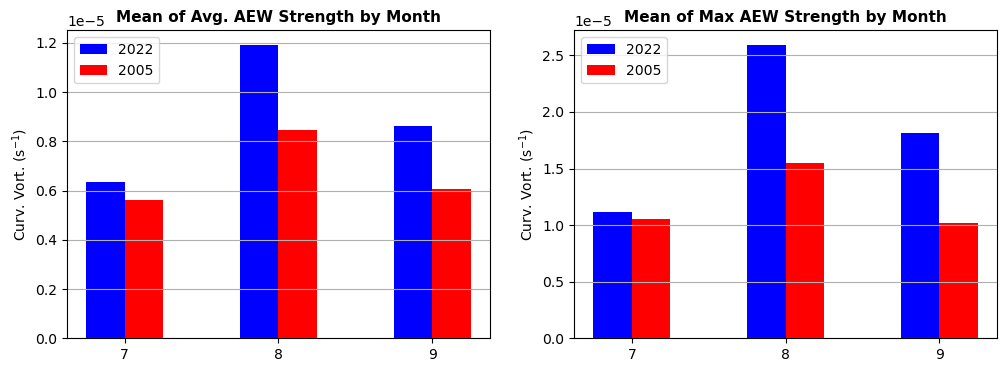

In [254]:
fig = plt.figure(figsize = (12, 4))

bar_width = 0.25
x = np.array([0,1,2])#0 and 1 are used as placeholders on x-axis for the three values, will be renamed

#### GRAPH 1: MEAN AVERAGE STRENGTH
ax = fig.add_subplot(121)
### Draw the "bars"
ax.bar(x, mean_values1['avg_str'], width = bar_width, color = 'b', label = str(year)) #Plot total count
ax.bar(x+bar_width, mean_values2['avg_str'], width = bar_width, color = 'r', label = str(year_compare)) #Plot TC count; notice the manual bar_width offset to put them side by side

### Now we want to label the x-axis correctly: one year should be on the "0" spot and comparison year the "1" spot
ax.set_xticks(x+bar_width/2) #bar_width/2 offset so we label right in the middle of the two bars
ax.set_xticklabels(month_list)

## Plot legend, make grid
ax.legend(loc = 'upper left')
ax.grid(axis = 'y')
ax.set_title('Mean of Avg. AEW Strength by Month', fontsize = 11, fontweight = 'bold')
ax.set_ylabel('Curv. Vort. (s$^{-1}$)')

#### GRAPH 2: MEAN MAX STRENGTH
ax2 = fig.add_subplot(122)
### Draw the "bars"
ax2.bar(x, mean_values1['max_str'], width = bar_width, color = 'b', label = str(year)) #Plot total count
ax2.bar(x+bar_width, mean_values2['max_str'], width = bar_width, color = 'r', label = str(year_compare)) #Plot TC count; notice the manual bar_width offset to put them side by side

### Now we want to label the x-axis correctly: one year should be on the "0" spot and comparison year the "1" spot
ax2.set_xticks(x+bar_width/2) #bar_width/2 offset so we label right in the middle of the two bars
ax2.set_xticklabels(month_list)

## Plot legend, make grid
ax2.legend(loc = 'upper left')
ax2.grid(axis = 'y')
ax2.set_title('Mean of Max AEW Strength by Month', fontsize = 11, fontweight = 'bold')
ax2.set_ylabel('Curv. Vort. (s$^{-1}$)')

## Part 2, Exercise 1: Try this out with different years! Compare them and see what interesting things you can find for these comparisions

## Part 2, Exercise 2: Try finding another attribute to compute, compare, and graph! Some examples to consider are:

### 1. The average latitude of AEWs
### 2. The number of AEWs originating over Africa versus elsewhere ("over_africa" attribute could be useful...)
### 3. The average longitude/latitude of AEW track start and ending
### 4. Or, something else! Tons of things

## Part 3, Exercise 1: Can you figure out a way to overlay the monthly AEW tracks (part 2) over their corresponding enviornmental plots (part 1)?